# Projet Big Data
Réalisé par :
- Sonia REFFAD
- Manel AIN GUERAD
- Maroua GHAOUAT

**Master AMSD 2023/2024**

# Chargement des packages et importation des libraries

In [1]:
!pip install apache-beam[interactive]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.1/677.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.8/307.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.2/809.2 kB 12.9 MB/s 

In [2]:
import random
import numpy as np
import pandas as pd
import apache_beam as beam
import os

from apache_beam.transforms.userstate import BagStateSpec

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix

---

# A. Implémentation de k-means séquentiel

## 1.1. Générer un jeu de données consistant en des points répartis en deux classes.

In [ ]:
# Génération aléatoire de points autour de centroïdes spécifiques
np.random.seed(42)

# Définition des centroïdes
centroid_1 = np.array([5, 5])
centroid_2 = np.array([10, 10])

# Génération des points autour des deux centroïdes
points_1 = centroid_1 + np.random.randn(100, 2)
points_2 = centroid_2 + np.random.randn(100, 2)

# Fusion des points et attribution des classes
data = np.vstack((points_1, points_2))
labels = np.array([0] * 100 + [1] * 100)  # Classe 0 pour les points autour de centroid_1, Classe 1 pour les points autour de centroid_2

## 1.2. Enregistre les données dans un fichier CSV

In [ ]:
# Création d'un DataFrame pandas
df = pd.DataFrame(data, columns=['X', 'Y'])
df['Label'] = labels

def write_to_csv(element):
  with open("clustering_results_1.csv", 'a') as f:
        f.write(str(element[0]) + '\n')

for i in df :
    write_to_csv(i)
# Enregistrement des données au format CSV
df.to_csv('donnees_points.csv', index=False)

## 2. Lire les données en consommant peu de mémoire

In [ ]:
chunk_size = 10  # Nombre de lignes à lire à la fois

data_chunks = pd.read_csv('donnees_points.csv', chunksize=chunk_size)

# Traiter les données chunk par chunk
for chunk in data_chunks:
    print(chunk.head())

          X         Y  Label
0  5.496714  4.861736      0
1  5.647689  6.523030      0
2  4.765847  4.765863      0
3  6.579213  5.767435      0
4  4.530526  5.542560      0
           X         Y  Label
10  6.465649  4.774224      0
11  5.067528  3.575252      0
12  4.455617  5.110923      0
13  3.849006  5.375698      0
14  4.399361  4.708306      0
           X         Y  Label
20  5.738467  5.171368      0
21  4.884352  4.698896      0
22  3.521478  4.280156      0
23  4.539361  6.057122      0
24  5.343618  3.236960      0
           X         Y  Label
30  4.520826  4.814341      0
31  3.893665  3.803793      0
32  5.812526  6.356240      0
33  4.927990  6.003533      0
34  5.361636  4.354880      0
           X         Y  Label
40  4.780328  5.357113      0
41  6.477894  4.481730      0
42  4.191506  4.498243      0
43  5.915402  5.328751      0
44  4.470240  5.513267      0
           X         Y  Label
50  3.584629  4.579355      0
51  4.657285  4.197723      0
52  4.838714  5.

## 3. Implémenter l’algorithme k-means séquentiel

In [ ]:
def k_means_sequential(data, k, max_iterations=100):
    # Initialisation aléatoire des centres (ou utiliser les premiers points)
    centers = data[np.random.choice(len(data), k, replace=False)]

    # Initialisation des effectifs et des clusters
    cluster_assignments = np.zeros(len(data))
    cluster_counts = np.zeros(k)

    for _ in range(max_iterations):
        # Assigner chaque point au cluster le plus proche
        for i, point in enumerate(data):
            distances = np.linalg.norm(centers - point, axis=1)
            closest_center = np.argmin(distances)
            cluster_assignments[i] = closest_center

            # Mettre à jour le centre du cluster et l'effectif
            cluster_counts[closest_center] += 1 # l'effectif
            eta = 1.0 / cluster_counts[closest_center]
            centers[closest_center] +=  eta * (point - centers[closest_center])

    return cluster_assignments, centers

In [ ]:
# Charger les données
data = pd.read_csv('donnees_points.csv')
data = data[['X', 'Y']].values

# Appliquer l'algorithme k-means avec k=2
clusters, centers = k_means_sequential(data, 2)

# Ajouter les clusters au DataFrame
df['Cluster'] = clusters

## 4. Enregistrer les résultats de l’algorithme dans un fichier

In [ ]:
# Définir la taille du chunk pour l'écriture
chunk_size = 10  # Nombre de lignes à écrire à la fois

# Fonction pour écrire les données chunk par chunk
def write_to_csv_chunks(df, filename, chunksize):
    with open(filename, 'w') as file:
        df_columns = df.columns.tolist()
        file.write(','.join(df_columns) + '\n')

        for i in range(0, len(df), chunksize):
            chunk = df.iloc[i:i+chunksize]
            chunk_string = chunk.to_csv(header=False, index=False)
            file.write(chunk_string)

# Écrire les résultats dans un fichier CSV par chunks
write_to_csv_chunks(df, 'resultats_kmeans.csv', chunk_size)

## 5. Valider la cohérence des résultats.

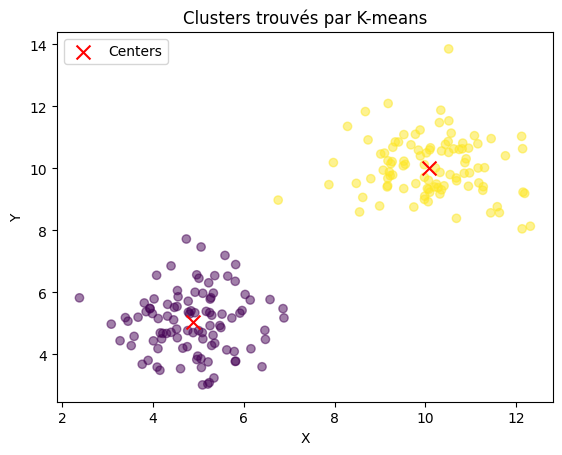

Indice de Silhouette : 0.7655973890178953


In [ ]:
# Visualisation des clusters
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='Centers')
plt.title('Clusters trouvés par K-means')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Calcul de l'indice de Silhouette
silhouette_avg = silhouette_score(data, clusters)
print(f"Indice de Silhouette : {silhouette_avg}")


Visuellement, nous arrivons à remarquer une bonne séparation entre les deux clusters, confirmée par l'indice de Silhouette qui est de ~**76%**.



---



# B. Implémentation d’une version streaming de k-means

## 1. Implémentation de l'algorithme K-Means en streaming

In [ ]:
def streaming_kmeans(batches, new_batch, initial_centroids, r=0.9, T=5, k=2):

    # Réduire la liste des lots pour conserver un maximum de T batches
    batches = [(batch, t) for batch, t in batches if t < T-1]
    # Add new batch with age 0
    batches.append((new_batch, 0))


    # Préparer les données pondérées et les poids pour le k-means
    weighted_data = np.vstack([batch for batch, _ in batches])
    # Appliquer une décroissance aux poids des batch
    weights = np.hstack([(r**t) * np.ones(len(batch)) for batch, t in batches])

    # Initialiser le k-means avec les centroïdes fournis s'ils sont donnés, sinon aléatoire
    init = initial_centroids if initial_centroids is not None and len(initial_centroids) == k else 'random'
    # Exécuter le k-means pondéré
    kmeans = KMeans(n_clusters=k, init=init, n_init=1)
    kmeans.fit(weighted_data, sample_weight=weights)

    return kmeans.cluster_centers_, kmeans.labels_


## 2. Diviser les données en batches

In [5]:
def stream_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]

## 3. Initialiser les paramètres, données et centroîds

In [ ]:
# Generate synthetic data
x, y = make_blobs(n_samples=[100, 100], centers=[(5, 5), (10, 10)], n_features=2)

n_clusters = 2
T = 15
r = 0.9
batch_size = 10
all_predicted_labels = []
batches=[]

all_data = np.array([]).reshape(0, 2)
centroids_history = []

# Initialiser avec un batch arbitraire
centroids = None
# Utilisation de max(len(centroids_history), 1) pour garantir au moins un sous-graphique
num_subplots = max(len(centroids_history), 1)
fig, axes = plt.subplots(num_subplots, 1, figsize=(6, 3 * num_subplots))

## 4. Simulation du streaming K-means avec plusieurs batches


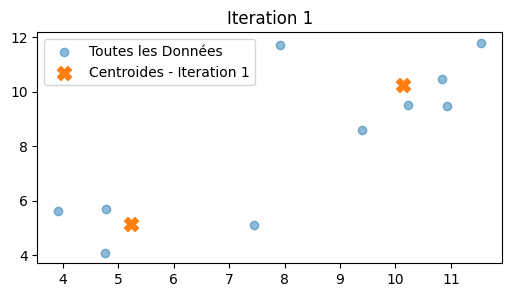

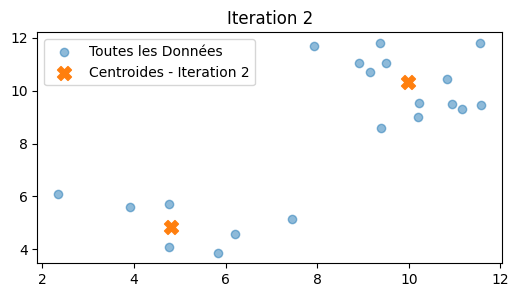

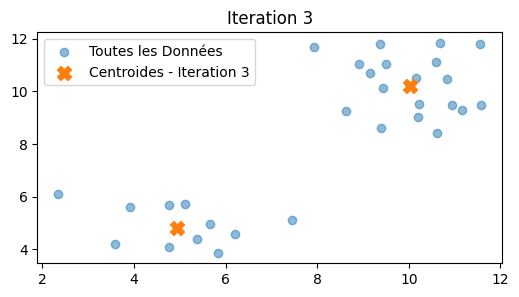

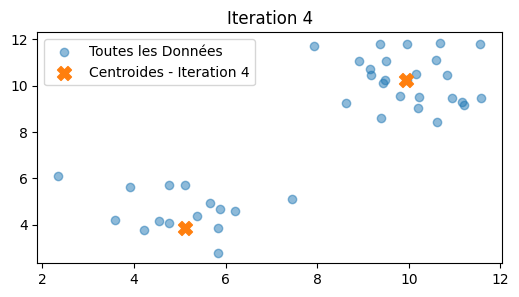

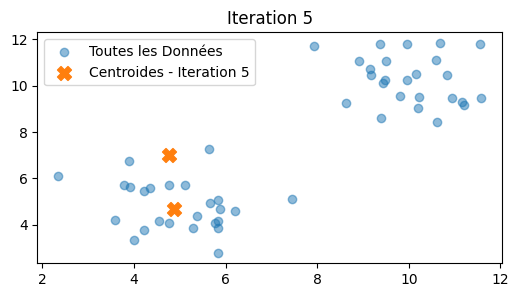

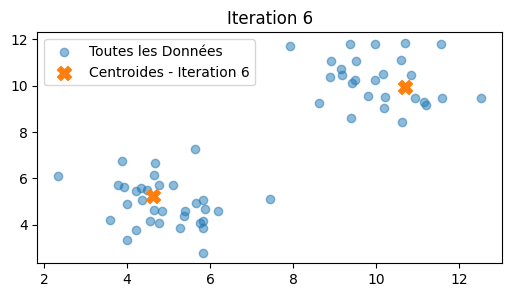

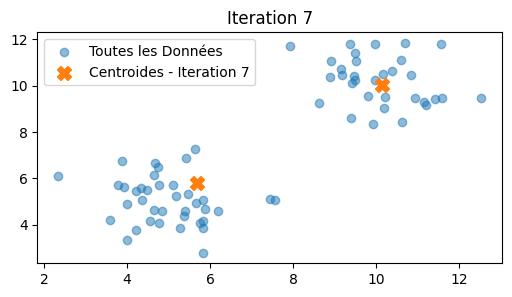

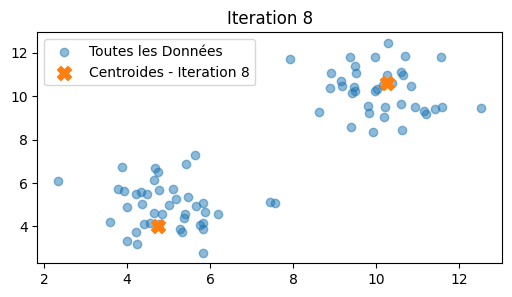

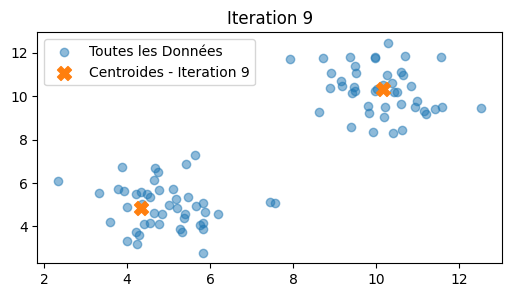

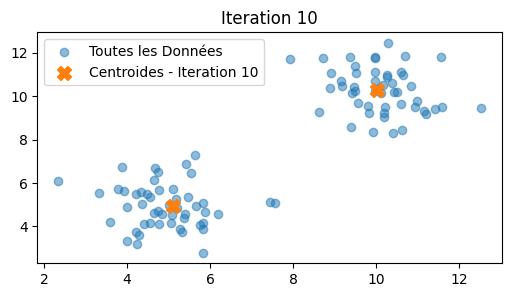

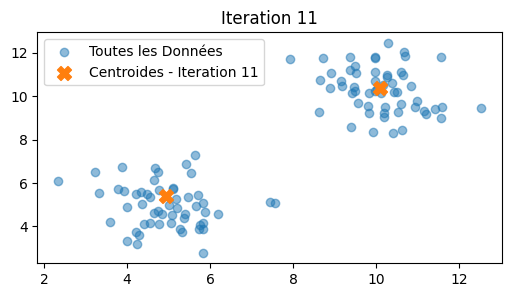

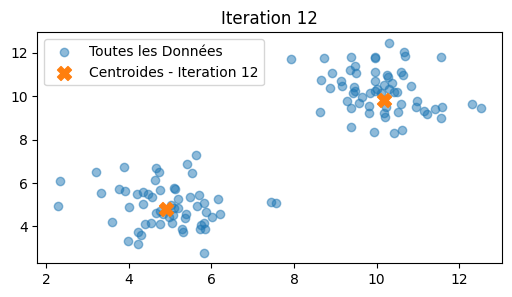

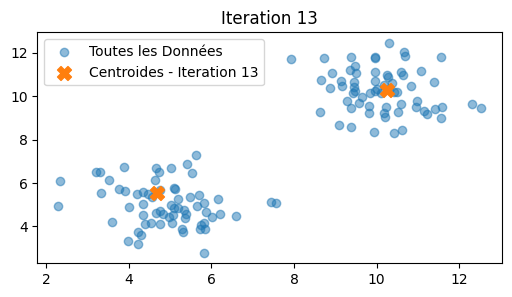

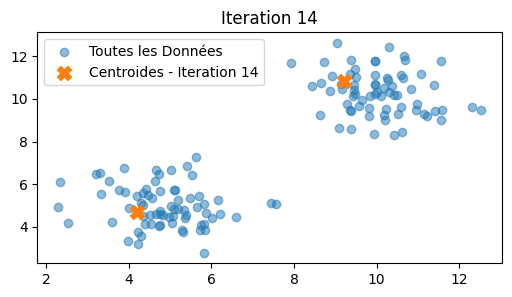

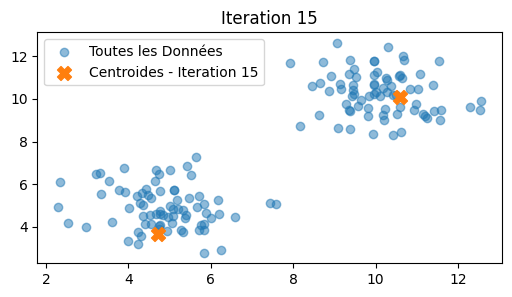

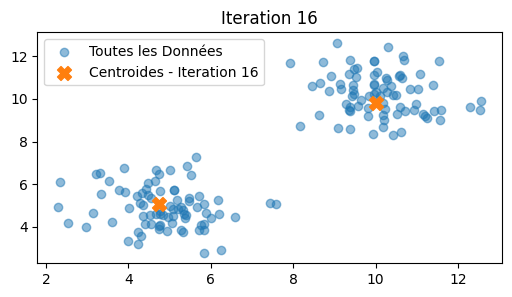

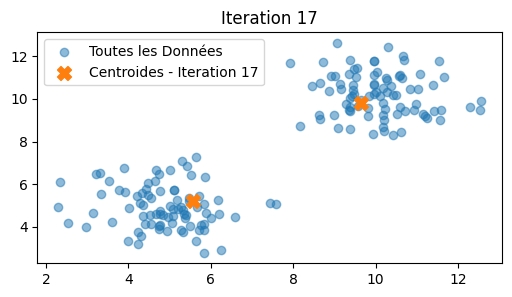

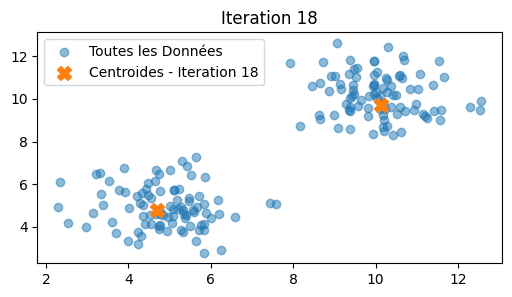

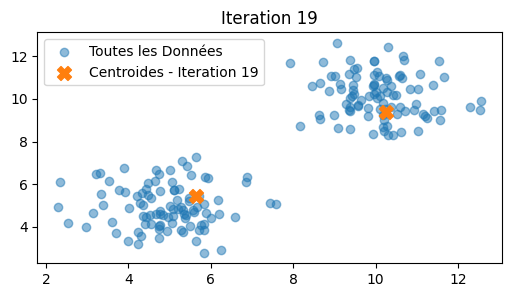

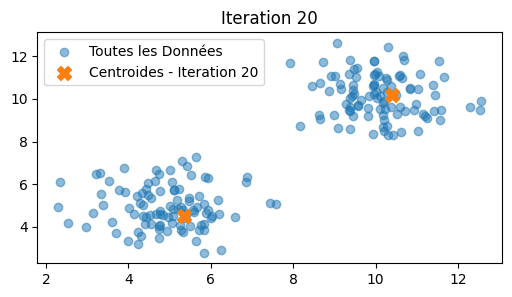

In [ ]:
for i, new_batch in enumerate(stream_batches(x, batch_size)):
    centroids, labels = streaming_kmeans(batches, new_batch,  centroids, r=r, T=T, k=n_clusters)
    centroids_history.append(centroids.copy())
    all_data = np.concatenate((all_data, new_batch))
    all_predicted_labels.extend(labels.tolist())

    # Créer un nouveau sous-graphique pour chaque itération
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.scatter(all_data[:, 0], all_data[:, 1], label='Toutes les Données', alpha=0.5)
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=100, label=f'Centroides - Iteration {i + 1}')
    ax.set_title(f'Iteration {i + 1}')
    ax.legend()
    plt.show()

## 5. Afficher les résultats et les valider

In [ ]:
# Afficher la matrice de confusion totale
final_conf_matrix = confusion_matrix(y, all_predicted_labels)
print("\nMatrice de confusion totale:")
print(final_conf_matrix)

# Afficher les graphiques
plt.show()


Matrice de confusion totale:
[[ 98   2]
 [  0 100]]




---


# **C. Implémentation de k-means distribué (Apache Beam)**


---



## 1. Créer une PCollection qui contient l’ensemble des points.

In [ ]:
 # nombre de clusters
nb_clusters = 2

In [ ]:
# Création du dataset
x, y = make_blobs(n_samples=[100, 100], centers=[(5,), (10,)], n_features=1)

In [ ]:
# Enregistrement des labels des données dans un fichier
with open("labels.csv", 'w') as csvfile:
    for label in y:
        csvfile.write(str(label) + '\n')

In [ ]:
# Enregistrement des données (points d'une dimension) dans un fichier
with open("data.csv", 'w') as csvfile:
    for point in x:
        csvfile.write(str(point[0]) + '\n')

In [ ]:
# Assigner un point x au centroid (sous forme de dictionnaire) le plus proche
def assign_point_dict(x, centroid):
    dist = [np.linalg.norm(x[1] - centroid[c]) for c in centroid.keys()]
    cluster_index = np.argmin(dist)

    # Enregistrement le résultat du clustering dans un fichiers csv
    with open("clustering_results.csv", 'a') as f:
        f.write(str(cluster_index) + '\n')

    return cluster_index, x[1]

In [ ]:
with beam.Pipeline() as pipeline:
    initialization = (
        pipeline
        | "Create PCollection of Points" >> beam.Create(x)                                                # Création des points
        | "Initialize Clusters" >> beam.Map(lambda point: (np.random.randint(nb_clusters), float(point))) # Initialisation aléatoire des centres
    )
    centroids = (
        initialization                                                                                    # Prendre la sortie de l'initialisation comme entrée
        | "Group classes" >> beam.GroupByKey()                                                            # Regrouper les points par centres
        | "Calculate centroids" >> beam.Map(lambda pair : (pair[0],sum(pair[1])/len(pair[1])))            # Màj des centres
    )
    assign_cluster = (
        initialization                                                                                    # Prendre la sortie de l'initialisation comme entrée
        | "Assignment" >> beam.Map(                                                                       # Assigner chaque point au centre le plus proche
            assign_point_dict,
            centroid = beam.pvalue.AsDict(centroids)                                                      # Un dictionnaire de centroïdes
        )
        | "Print results" >> beam.Map(print)                                                              # Afficher les résultats
    )

(1, 10.87571586240098)
(0, 6.196894951802416)
(1, 9.623085774586103)
(0, 4.397894647218742)
(0, 7.1289465557456)
(0, 3.984786596854785)
(0, 4.85526934871428)
(0, 5.536416732395043)
(1, 11.914712305997991)
(1, 9.763357814468954)
(1, 11.673938418122521)
(0, 5.2733667459719245)
(1, 10.428812314620698)
(0, 4.954119218019081)
(1, 10.85009398931681)
(0, 4.1436934305568505)
(1, 10.303444750924045)
(0, 4.170962541646793)
(0, 4.8336166706416765)
(1, 7.71585214251766)
(1, 10.307064516570243)
(0, 5.686566006151563)
(0, 4.644688113882066)
(0, 3.787542721150772)
(1, 9.17688193865192)
(1, 9.296728477436528)
(1, 10.46999826076317)
(1, 9.76300082893984)
(0, 5.619037198286294)
(1, 7.776387969004469)
(0, 5.860204242020484)
(1, 9.006621794416143)
(1, 9.271843223932214)
(1, 9.849164379393445)
(1, 9.828750824562915)
(0, 5.37249570979)
(0, 2.786772651973169)
(1, 9.984180289737932)
(1, 11.606119491831294)
(1, 10.129064798240169)
(1, 10.782493494700622)
(0, 5.185767492086772)
(0, 4.821390025452655)
(1, 10.029

In [ ]:
#matrice de confusion
labels = np.array(pd.read_csv('labels.csv',header=None))
clustering_results = np.array(pd.read_csv('clustering_results.csv',header=None))
confusion_matrix(clustering_results,labels)

array([[100,   1],
       [  0,  99]])

Les limitations de l'algorithme actuel résident dans le fait qu'il suppose la disponibilité en mémoire de tous les points lors du calcul du centroïde, ce qui peut être problématique en termes de consommation de mémoire dans le cas où nous disposons d'une masse de données. De plus, l'algorithme traite tous les centres simultanément sous forme de dictionnaire, ce qui peut également entraîner des inefficacités en termes de gestion de la mémoire.
Pour remédier à ces problèmes, nous pouvons adopter une approche où les centres sont transmis à travers un itérator en utilisant la fonction **beam.pvalue.AsIter**, ce qui permet de réduire la charge mémoire.

De plus, afin d'améliorer la qualité de l'algorithme, il peut être bénéfique d'effectuer plusieurs itérations de l'algorithme k-means dans le pipeline, permettant ainsi une convergence plus précise vers les centres finaux.

In [ ]:
# Assigner un point x au centroid le plus proche
def assign_point(x, centroid):
    dist = [np.linalg.norm(x[1] - c[1]) for c in centroid]
    cluster_index = np.argmin(dist)

    return cluster_index, x[1]

In [ ]:
def write_to_csv(element):
  with open("clustering_results_1.csv", 'a') as f:
        f.write(str(element[0]) + '\n')

In [ ]:
with beam.Pipeline() as pipeline:
    initialization = (
        pipeline
        | "Create PCollection of Points from file" >> beam.io.ReadFromText("data.csv")                    # Création des points
        | "Initialize Clusters" >> beam.Map(lambda point: (np.random.randint(nb_clusters), float(point))) # Initialisation aléatoire des centres
    )

    assign_cluster = initialization
    for i in range(5):
        centroids = (
            initialization                                                                                    # Prendre la sortie de l'initialisation comme entrée
            | "Group class iter " + str(i) >> beam.GroupByKey()                                                            # Regrouper les points par centres
            | "Calculate centroid iter " +str(i) >> beam.Map(lambda pair : (pair[0],sum(pair[1])/len(pair[1])))            # Màj des centres
        )
        assign_cluster=(
            assign_cluster
            | "Assignment iter " +str(i) >> beam.Map(                                                                       # Assigner chaque point au centre le plus proche
                assign_point,
                centroid = beam.pvalue.AsIter(centroids)                                                      # Les centroïdes en itération
            )
        )
    save_in_file = (
        assign_cluster
        | "Write classes to CSV" >> beam.Map(write_to_csv)                                              # Enregistrer les résultats dans un fichier csv
    )
    output = (
        assign_cluster                                                                                    # Prendre la sortie du pipe précédant comme entrée
        | "Print results" >> beam.Map(print)                                                              # Afficher les résultats
    )

(0, 10.87571586240098)
(1, 6.196894951802416)
(0, 9.623085774586103)
(1, 4.397894647218742)
(1, 7.1289465557456)
(1, 3.984786596854785)
(1, 4.85526934871428)
(1, 5.536416732395043)
(0, 11.914712305997991)
(0, 9.763357814468954)
(0, 11.673938418122521)
(1, 5.2733667459719245)
(0, 10.428812314620698)
(1, 4.954119218019081)
(0, 10.85009398931681)
(1, 4.1436934305568505)
(0, 10.303444750924045)
(1, 4.170962541646793)
(1, 4.8336166706416765)
(0, 7.71585214251766)
(0, 10.307064516570243)
(1, 5.686566006151563)
(1, 4.644688113882066)
(1, 3.787542721150772)
(0, 9.17688193865192)
(0, 9.296728477436528)
(0, 10.46999826076317)
(0, 9.76300082893984)
(1, 5.619037198286294)
(0, 7.776387969004469)
(1, 5.860204242020484)
(0, 9.006621794416143)
(0, 9.271843223932214)
(0, 9.849164379393445)
(0, 9.828750824562915)
(1, 5.37249570979)
(1, 2.786772651973169)
(0, 9.984180289737932)
(0, 11.606119491831294)
(0, 10.129064798240169)
(0, 10.782493494700622)
(1, 5.185767492086772)
(1, 4.821390025452655)
(0, 10.029

In [ ]:
labels = np.array(pd.read_csv('labels.csv',header=None))
clustering_results = np.array(pd.read_csv('clustering_results_1.csv',header=None))
confusion_matrix(clustering_results,labels)

array([[  0,  99],
       [100,   1]])



---


# **D. Implémentation de k-means séquentiel distribuée (Apache Beam)**


---



In [ ]:
x, y = make_blobs(n_samples=[100, 100], centers=[(5,), (10,)], n_features=1)

In [ ]:
class kmeans(beam.DoFn):
    centroids_state = BagStateSpec(name='centroids', coder = beam.coders.PickleCoder())   # Etat contenant le cluster, son centroid et le nb d'élements contenus dans la partition
    clusters_state = BagStateSpec(name='clusters', coder = beam.coders.PickleCoder())     # Etat contenant le cluster et ses points associés

    def process(self, element, centroids=beam.DoFn.StateParam(centroids_state), clusters =beam.DoFn.StateParam(clusters_state) ):
        key, value = element
        state_centroid = list(set(centroids.read()))
        state_cluster = list(set(clusters.read()))

        # Si on ne possède pas de nb_clusters centroid on concidère le nouveau point comme centroid
        if(len(state_centroid) < nb_clusters):
            centroids.add((len(state_centroid),value,1))
            clusters.add((len(state_centroid),value))
        else :
          distances = []
          point=value
          for cluster, center_coordinates, n in state_centroid :
                distances.append(np.linalg.norm(point - center_coordinates))    # Calculer la distance du point avec chaque centroid
          label = np.argmin(distances)        # attribuer le point au centroid de la classe le plus proche
          cluster, center_coordinates, n = state_centroid[label]      # Sauvegarder l'état actuel : label de la classe, les coordonnées du centroid, nb d'éléments de la classe
          n=n+1     #Màj de n
          center_coordinates += (1/n ) * (point - center_coordinates)   # Màj des coordonnées du centroid

          clusters.add((cluster,point))       # Ajouter le nouveau point au cluster
          state_centroid[label]= cluster, center_coordinates, n   # Màj de l'état du cluster

          # Ecraser l'état avec les données actuelle
          centroids.clear()
          for i in state_centroid:
              centroids.add((i))

        yield state_centroid, set(clusters.read())


In [ ]:
with beam.Pipeline() as pipeline:
    initialization = (
        pipeline
        | "Create PCollection" >> beam.Create(x)                                # Création des points
        | "Initialize Clusters" >> beam.Map(lambda point: (0, float(point)))    # Initialisation des centres (cluster 0)
    )

    (initialization
        | "ParDO" >> beam.ParDo(kmeans())                                       # Méthode kmeans séquentielle
        | "Print" >> beam.Map(print)                                            # Affichage des résultats
    )

([], {(0, 6.725907770352374)})
([(0, 6.725907770352374, 1)], {(1, 9.531817208690956), (0, 6.725907770352374)})
([(0, 5.801089717042601, 2), (1, 9.531817208690956, 1)], {(0, 4.876271663732827), (1, 9.531817208690956), (0, 6.725907770352374)})
([(1, 9.531817208690956, 1), (0, 5.256892497043035, 3)], {(0, 4.168498057043903), (0, 4.876271663732827), (1, 9.531817208690956), (0, 6.725907770352374)})
([(1, 9.531817208690956, 1), (0, 4.84695262846872, 4)], {(0, 3.617133022745775), (1, 9.531817208690956), (0, 6.725907770352374), (0, 4.876271663732827), (0, 4.168498057043903)})
([(1, 10.321767888107573, 2), (0, 4.84695262846872, 4)], {(0, 3.617133022745775), (1, 11.11171856752419), (1, 9.531817208690956), (0, 6.725907770352374), (0, 4.876271663732827), (0, 4.168498057043903)})
([(0, 4.84695262846872, 4), (1, 10.159706445251254, 3)], {(1, 9.835583559538618), (0, 3.617133022745775), (1, 11.11171856752419), (1, 9.531817208690956), (0, 6.725907770352374), (0, 4.876271663732827), (0, 4.16849805704390

---

# E. Implémentation d’une version streaming et distribuée de k-means

In [6]:
class KMeansDoFn(beam.DoFn):
    batchs = BagStateSpec('batchs', beam.coders.PickleCoder())

    def __init__(self, r, k):
        self.r = r
        self.k = k

    def process(self, element, bag_state=beam.DoFn.StateParam(batchs)):
        key, value = element
        batches = list(bag_state.read())
        # Réduire la liste des lots pour conserver un maximum de T batchs
        batches = [(batch, t) for batch, t in batches if t < self.T - 1]

        # Ajouter un nouveau batch avec un âge de 0
        batches.append((value, 0))


        # Préparer les données pondérées et les poids pour le k-means
        weighted_data = np.vstack([batch for batch, _ in batches])
        weights = np.hstack([(self.r ** t) * np.ones(len(batch)) for batch, t in batches])


        # Exécuter le k-means pondéré
        kmeans = KMeans(n_clusters=self.k, init='random', n_init=1)
        kmeans.fit(weighted_data, sample_weight=weights)

        # Sauvegarder les batches in dans la variable d'état
        bag_state.clear()
        bag_state.add(batches)

        yield kmeans.cluster_centers_.tolist(), kmeans.labels_.tolist()


In [7]:
# Parameters
n_clusters = 2
T = 15
r = 0.9
batch_size = 10

# Your streaming data
x, y = make_blobs(n_samples=[100, 100], centers=[(5, 5), (10, 10)], n_features=2)

streaming_data = [(i, new_batch)  for i, new_batch in enumerate(stream_batches(x, batch_size))]


# Create a Beam pipeline
with beam.Pipeline() as pipeline:
    results = (
        pipeline
        | "Create PCollections from Streaming Data" >> beam.Create(streaming_data)
        | "Batch by Size" >> beam.WindowInto(beam.transforms.window.FixedWindows(T))
        | "Apply KMeans" >> beam.ParDo(KMeansDoFn(r, n_clusters))
    )

    # You can further process or write the results as needed
    results | beam.Map(print)


([[9.806596903247584, 10.094453652228573], [5.123644464760227, 5.572800559634122]], [1, 0, 0, 1, 0, 1, 1, 1, 1, 1])
([[9.669284716269395, 10.31556940009738], [5.165300639981982, 5.657554288576042]], [0, 0, 1, 0, 1, 0, 0, 1, 1, 1])
([[5.043318716156596, 5.414497320628036], [10.046941375153956, 10.494273007192016]], [0, 0, 1, 0, 0, 1, 1, 0, 0, 0])
([[10.060555954375262, 9.439355497326979], [4.477307149825155, 4.608330872225576]], [0, 1, 1, 1, 0, 0, 0, 1, 1, 1])
([[10.199436956446007, 9.440384682930324], [5.312475036995323, 4.812180752048498]], [0, 0, 0, 1, 0, 0, 0, 1, 1, 1])
([[3.4077379145798705, 3.46981516080666], [10.313585256598596, 9.479607390028807]], [1, 1, 0, 1, 1, 1, 0, 1, 1, 1])
([[5.70058994012259, 4.468077881083932], [9.935665144513766, 9.710802103896025]], [0, 1, 1, 1, 1, 1, 0, 0, 1, 1])
([[9.84064642479819, 10.181676277143875], [5.415008623080188, 4.132835596217248]], [1, 1, 0, 1, 0, 0, 1, 0, 0, 0])
([[9.900783845317353, 10.068841631139229], [5.196126744257476, 5.5868950884